In [55]:
import numpy as np

class Grid:
    def __init__(self, a, b, N):
        self.a = a
        self.b = b
        self.N = N
        self.x_values = np.linspace(a, b, N + 1)
        self.delta_x = (b - a) / N

def create_matrices(alpha, beta, grid, condition_type):
    N = grid.N
    delta_x = grid.delta_x

    # Initialize the matrix A and the vector b
    A = np.zeros((N + 1, N + 1))
    b = np.zeros(N + 1)

    # Populate the matrix A according to the central difference scheme
    for i in range(1, N):
        A[i, i - 1] = 1
        A[i, i] = -2
        A[i, i + 1] = 1

    if condition_type == 'Dirichlet':
        A[0, 0] = 1
        A[N, N] = 1
        b[0] = alpha
        b[N] = beta

    elif condition_type == 'Neumann':
        A[0, 0] = -2
        A[0, 1] = 1
        A[N, N - 1] = 2
        A[N, N] = -2

        b[0] = alpha
        b[N] = 2*beta*delta_x

    return A, b
        

In [56]:
b = 0
a = 1
gamma0 = 0
gamma1 = 10
N = 10

grid = Grid(a, b, N)

A_DD, b_DD = boundary_conditions(gamma0, gamma1, N)

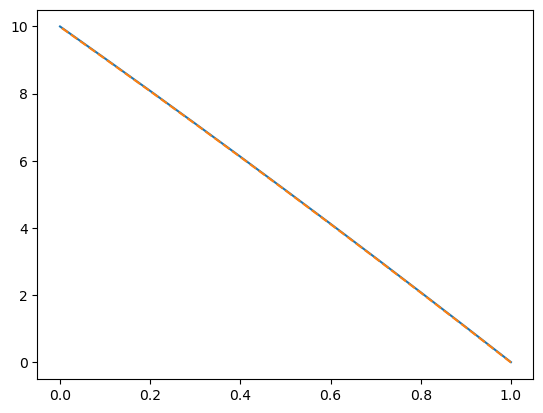

In [54]:
def q(x):
    return 1

def u(x):
    return -1/2 * (x - a) * (x - b) + ((gamma1 - gamma0) / (b - a)) * (x - a) + gamma0

# Even spacing in 1D
x = np.linspace(a, b, N + 1)
y = u(x)

# Plot the solution
import matplotlib.pyplot as plt
plt.plot(x, y)

# Solve numerically
q_x = q(grid.x_values)
sol = np.linalg.solve(A_DD, b_DD - grid.delta_x**2 * q_x)

# Plot the solution
plt.plot(grid.x_values, sol, '--')
plt.show()

C:\Users\duppu\AppData\Local\Temp\ipykernel_17256\3277623813.py:13: RuntimeWarning: overflow encountered in exp
  return np.exp(mu*u)


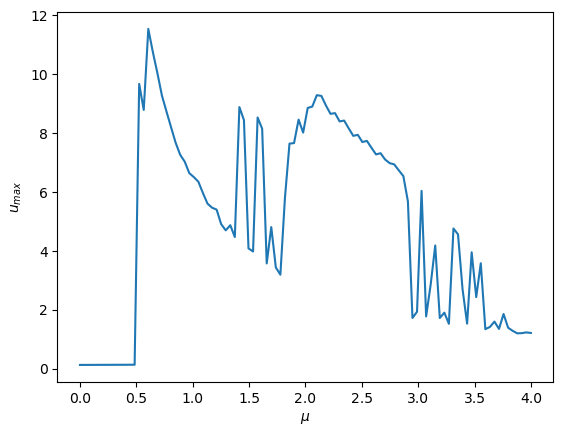

In [69]:
a = 0
b = 1
alpha = 0
beta = 0

N = 10

max_u = []
for mu in np.linspace(0, 4, 100):
    D = 1

    def q(x, u, mu):
        return np.exp(mu*u)

    grid = Grid(a, b, N)
    u_array = u(grid.x_values)
    x_array = grid.x_values

    def func(u_array):

        equations = np.zeros(N + 1)

        equations[0] = D*(u_array[2] - 2 * u_array[1] + alpha) / grid.delta_x**2 + q(x_array[0],u_array[0], mu)

        for i in range(1, N):
            equations[i] = D*(u_array[i - 1] - 2 * u_array[i] + u_array[i + 1]) / grid.delta_x**2 + q(x_array[i],u_array[i], mu)
        
        equations[N] = D*(u_array[N - 2] - 2 * u_array[N - 1] + beta) / grid.delta_x**2 + q(x_array[N],u_array[N], mu)

        return equations

    from scipy.optimize import root

    sol = root(func, u_array)
    u_sol = sol.x
    max_u.append(max(u_sol))

plt.plot(np.linspace(0, 4, 100), max_u)
plt.xlabel(r'$\mu$')
plt.ylabel(r'$u_{max}$')
plt.show()

In [29]:
import numpy as np

class BVP:
    def __init__(self, a, b, N, alpha, beta=None, delta=None, gamma=None, condition_type=None):
        self.a = a
        self.b = b
        self.alpha = alpha
        self.beta = beta
        self.delta = delta
        self.gamma = gamma
        self.N = N
        self.condition_type = condition_type

        # Check that the boundary conditions are valid
        self.check_boundary_validity()

        # Create the grid
        self.grid()

    
    def check_boundary_validity(self):
        if self.condition_type == 'Dirichlet':
            if self.alpha is None or self.beta is None:
                raise ValueError('alpha and beta must be specified for Dirichlet boundary conditions')

        elif self.condition_type == 'Neumann':
            if self.alpha is None or self.delta is None:
                raise ValueError('alpha and delta must be specified for Neumann boundary conditions')
            
        elif self.condition_type == 'Robin':
            if self.alpha is None or self.delta is None or self.gamma is None:
                raise ValueError('alpha, delta and gamma must be specified for Robin boundary conditions')
            
        else:
            raise ValueError('condition_type must be either Dirichlet or Neumann or Robin')
            

    def grid(self):
        self.x_values = np.linspace(self.a, self.b, self.N + 1)
        self.delta_x = (self.b - self.a) / self.N


    def dirichlet_boundary_conditions(self):
        N = self.N
        delta_x = self.delta_x

        # Initialize the matrix A and the vector b
        A = np.zeros((N - 1, N - 1))
        b = np.zeros(N - 1)

        # Populate the matrix A according to the central difference scheme
        for i in range(1, N-2):
            A[i, i - 1] = 1
            A[i, i] = -2
            A[i, i + 1] = 1

        A[0, 0] = -2
        A[0, 1] = 1
        A[N-2, N-2] = -2
        A[N-2, N - 3] = 1
        b[0] = self.alpha
        b[N-2] = self.beta

        return A, b
    
    def neumann_boundary_conditions(self):
        N = self.N
        delta_x = self.delta_x

        # Initialize the matrix A and the vector b
        A = np.zeros((N, N))
        b = np.zeros(N)

        # Populate the matrix A according to the central difference scheme
        for i in range(1, N-1):
            A[i, i - 1] = 1
            A[i, i] = -2
            A[i, i + 1] = 1

        A[0, 0] = -2
        A[0, 1] = 1
        A[N-1, N-1] = -2 * (1 + self.delta * delta_x)
        A[N-1, N-2] = 2
        b[0] = self.alpha
        b[N-1] = 2 * self.delta * delta_x

        return A, b
    
    def robin_boundary_conditions(self):
        N = self.N
        delta_x = self.delta_x

        # Initialize the matrix A and the vector b
        A = np.zeros((N, N))
        b = np.zeros(N)

        # Populate the matrix A according to the central difference scheme
        for i in range(1, N-1):
            A[i, i - 1] = 1
            A[i, i] = -2
            A[i, i + 1] = 1

        A[0, 0] = -2
        A[0, 1] = 1
        A[N-1, N-1] = -2
        A[N-1, N-2] = 2
        b[0] = self.alpha
        b[N-1] = 2 * self.gamma * delta_x

        return A, b
    
    
    def boundary_conditions(self):
        if self.condition_type == 'Dirichlet':
            return self.dirichlet_boundary_conditions()
        
        elif self.condition_type == 'Neumann':
            return self.neumann_boundary_conditions()
        
        elif self.condition_type == 'Robin':
            return self.robin_boundary_conditions()
    
# bvp = BVP(a=0, b=1, N=10, alpha=0, beta=0, condition_type='Dirichlet')
bvp = BVP(a=0, b=1, N=10, alpha=0, delta=5, condition_type='Neumann')
# bvp = BVP(a=0, b=1, N=10, alpha=0, delta=5, gamma=1, condition_type='Robin')
# bvp.dirichlet_boundary_conditions()
# bvp.neumann_boundary_conditions()
bvp.boundary_conditions()

None
0.1


(array([[-2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1., -2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  1., -2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  1., -2.,  1.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1., -2.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  1., -2.,  1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  1., -2.,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  1., -2.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -2.,  1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2., -3.]]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]))